### Fig S 18S probe test
- S1A-S1C: thermodynamic properties vs. performance for the 20 probes
- S1D: Tm by position in 18S
- S1E: Performance of low vs. high Tm probes

In [1]:
#Imports
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import gffutils
import seaborn as sns
import numpy as np
import scipy.stats as stats

sys.path.append('../scripts/')
from plot_helpers import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#load properties of probes
prop_file = '../figures/F1/TableS1_18S_candidate_properties.csv'
df = pd.read_csv(prop_file)
df['percent_remaining'] = df['mean_frac_remaining']*100

#Annotate id labels with categories
pool2_ids = range(21, 31)
lowtm_pool1_ids = range(1, 12)

df['length_category'] = df['probe_num'].apply(lambda x: '~30mer' if x <= 30 else '~50mer')
df['tm_category'] = df['probe_num'].map(lambda x: 'high Tm' if x in pool2_ids else ('low Tm' if x in lowtm_pool1_ids else np.nan))

In [3]:
#Make outdir and load the data
outdir = '../figures/FS2'
os.makedirs(outdir, exist_ok = True)

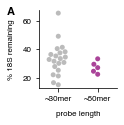

In [4]:
#Fig S1A: plot longer probes vs shorter probes
panel_name = 'S2A'

plot = Plotter(corners = [0.27, 0.27, 0.68, 0.68], figsize = (sfig, sfig))
plot.nudge_corners(bottom = True, right = True)
plot.setup_axis()
#Not sure why it does a better job here not overlapping the points than in F1
plot.ax = sns.swarmplot(x = 'length_category', y = 'percent_remaining', 
                        data = df.loc[(df['probe_num'] < 21) | (df['probe_num'] > 30)], 
                       ax = plot.ax)
plot.set_ylabel('% 18S remaining')
plot.set_xlabel('probe length')
plot.add_letter('A')
plt.savefig(os.path.join(outdir, '{}.{}'.format(panel_name, outfmt)), dpi = 600)

/Users/maryk.thompson/miniconda3/envs/plotting/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


0.9949797739432688


/Users/maryk.thompson/miniconda3/envs/plotting/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


0.6516702358175535


/Users/maryk.thompson/miniconda3/envs/plotting/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


0.07334086574364809


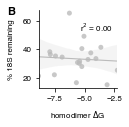

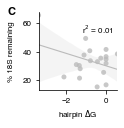

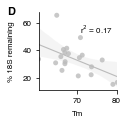

In [11]:
#Fig S2B - S2D: Plotting depletion vs thermodynamic properties for the first 20 probes
#https://stackoverflow.com/questions/1452995/why-doesnt-a-python-dict-update-return-the-object
to_plot = ['homodimer_dG', 'hairpin_dG', 'Tm']
x_label_dict = {'homodimer_dG': r'homodimer $\Delta$G', 'hairpin_dG': r'hairpin $\Delta$G', 'Tm': 'Tm'}
first_df = df.loc[df['probe_num'] < 21].copy()

default_margins = {'top':False, 'bottom':False, 'left':False, 'right':False}
to_plot = {'homodimer_dG': {'letter': 'B', 'margins': dict(default_margins, **{'bottom':True, 'left':True})},
          'hairpin_dG': {'letter': 'C', 'margins': dict(default_margins, **{'top': True, 'right':True})},
          'Tm': {'letter': 'D', 'margins': dict(default_margins, **{'top':True, 'left':True})}}

for i in to_plot:
    panel_name = 'S2{}'.format(to_plot[i]['letter'])
    plot = Plotter(corners = [0.27, 0.27, 0.68, 0.68], figsize = (sfig, sfig))
    plot.nudge_corners(top = to_plot[i]['margins']['top'], bottom = to_plot[i]['margins']['bottom'], 
                       left = to_plot[i]['margins']['left'], right = to_plot[i]['margins']['right'])
    plot.setup_axis()
    
    #create a little space on the left and right so the the points don't get cutoff
    #but the seaborn generated components only extend to the data range, so keep as is
    #min_x = first_df[i].min() - abs(first_df[i].min()*0.05)
    #max_x = first_df[i].max() + abs(first_df[i].max()*0.05)
    
    plot.ax = sns.regplot(x = i, y = 'percent_remaining', data = first_df, ax = plot.ax, scatter_kws = {'edgecolors': 'none'})
    r_value = stats.spearmanr(first_df[i], first_df['percent_remaining'])

    r_squared = r_value[0]**2
    p_value = r_value[1]
    plot.ax.annotate('r'r'$^2$'' = %1.2f' % r_squared, xy=(0.95, 0.85), annotation_clip=False, 
                     xytext=None, textcoords='axes fraction',fontsize = 8, arrowprops=None, 
                     ha = 'right', va = 'top')
    
    plot.set_ylabel('% 18S remaining')
    plot.set_xlabel(x_label_dict[i])
    plot.add_letter(to_plot[i]['letter'])
    
    print(p_value)
    plt.savefig(os.path.join(outdir, '{}.{}'.format(panel_name, outfmt)), dpi = 600)

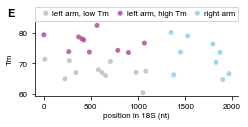

In [6]:
#Fig S1E: Plot Tm vs. 18S position for the selected probes
panel_name = 'S2E'
plot = Plotter(corners = [0.12, 0.24, 0.855, 0.64], figsize = (sfig*2, sfig))
plot.nudge_corners(top = True)
plot.setup_axis()

short_df = df.loc[df['probe_num'] < 31].copy()
left_low = plot.ax.scatter(*short_df[short_df['tm_category'] == 'low Tm'][['consensus_start', 'Tm']].transpose().values, alpha = 0.8, edgecolors = 'none')
left_hi = plot.ax.scatter(*short_df[short_df['tm_category'] == 'high Tm'][['consensus_start', 'Tm']].transpose().values, alpha = 0.8, edgecolors = 'none')
right_mixed = plot.ax.scatter(*short_df[short_df['tm_category'].isnull()][['consensus_start', 'Tm']].transpose().values, alpha = 0.8, edgecolors = 'none')
plot.ax.legend([left_low, left_hi, right_mixed], ['left arm, low Tm', 'left arm, high Tm', 'right arm'], 
               mode = 'expand', fontsize = 8, ncol = 3, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, 
               borderaxespad=0., handletextpad = -0.2)

plot.set_ylabel('Tm')
plot.set_xlabel('position in 18S (nt)')
plot.add_letter('E')

plt.savefig(os.path.join(outdir, '{}.{}'.format(panel_name, outfmt)), dpi = 600)